# Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import static_utils

%matplotlib inline

# Constants and Paths

In [2]:
# Main data paths for each catheter (manually input)
parent_path = '../data/processed'
main_path_222 = parent_path + '/static/trackTest-9Nov2021-C222-Y2/'
main_path_231 = parent_path + '/static/trackTest-9Jan2022-C231-Y2/'
main_path_306 = parent_path + '/static/trackTest-7Jan2022-C306-Y2/'

main_path = [main_path_222, main_path_231, main_path_306]

# Where you would like to save the heatmaps (manually input)
heatmap_path = '../reports/figures/static/Y-5mm/'

Gt_filename = '1GroundTruthCoords.csv'

geometry_index = 1

# Error Heatmaps for Y= -5 mm

For each sequence and localization algorithm of interest, plot the heatmap of average tip errors at each position. Each position has recordings from three catheters, except for one position from the conventional 3-projection sequence which has only two recordings.

Tip Tracking Error @ Y = -5mm sequence SRI_Original, algorithm centroid_around_peak


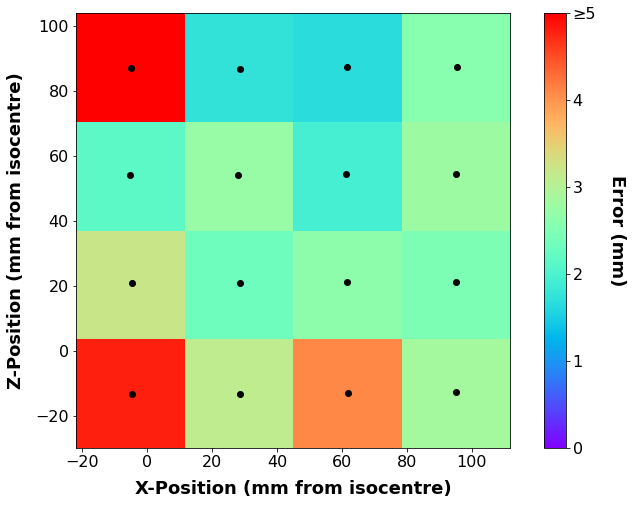

Tip Tracking Error @ Y = -5mm sequence SRI_Original, algorithm jpng


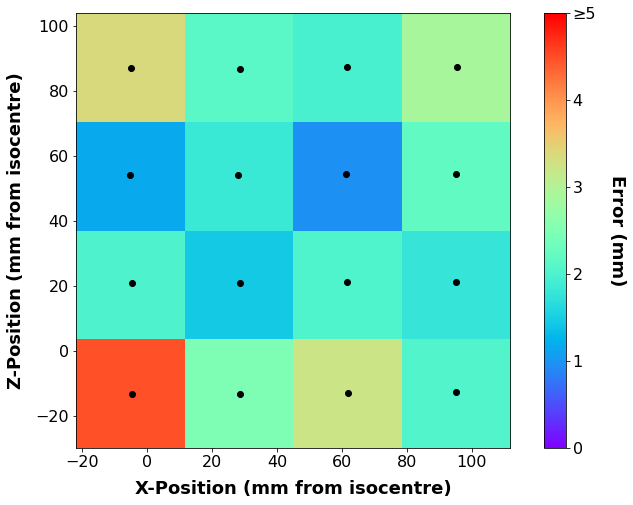

Tip Tracking Error @ Y = -5mm sequence FH512_noDither_gradSpoiled, algorithm centroid_around_peak


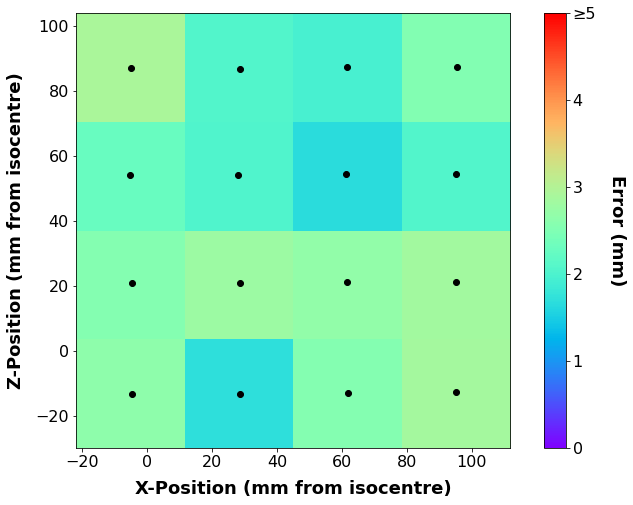

Tip Tracking Error @ Y = -5mm sequence FH512_noDither_gradSpoiled, algorithm jpng


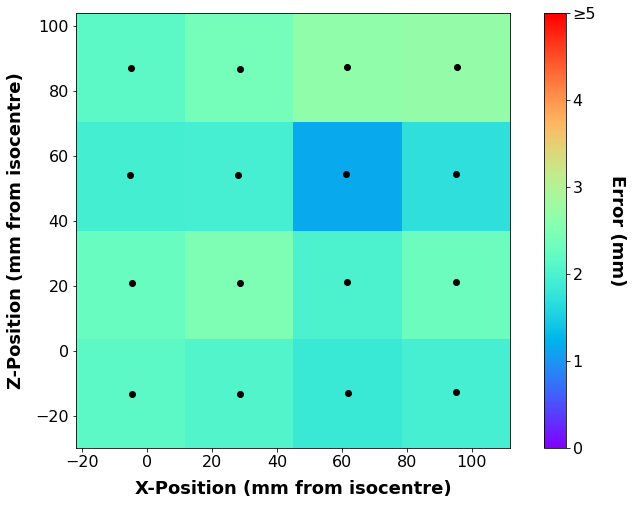

In [3]:
sequences = ['SRI_Original', 'FH512_noDither_gradSpoiled']
algorithms = ['centroid_around_peak', 'jpng']

for seq in sequences:
    for alg in algorithms:
        path_dct = static_utils.get_catheter_data(main_path, seq, alg, Gt_filename, geometry_index)
        # Average the error
        avg_all_caths = (path_dct[main_path_222] + path_dct[main_path_231] + path_dct[main_path_306]) / 3
        if seq == 'SRI_Original':
            # The missing recording results in one invalid 0 mm error in the path_dct
            avg_all_caths[1, 2] = avg_all_caths[1, 2] * 3/2 # recover total sum, then divide by 2 for mean
        avg_err = avg_all_caths[:, 2]
        my_data = np.array([avg_all_caths[:, 0], avg_all_caths[:, 1], avg_err]).T
        
        X = my_data[:, 0]
        Y = my_data[:, 1]
        Z = my_data[:, 2]

        heatmap = static_utils.nonuniform_imshow(X, Y, Z)
        plt.gca().invert_yaxis()
        plt.xlabel('X-Position (mm from isocentre)', fontsize = 18, fontweight = 'bold', labelpad = 10)
        plt.ylabel('Z-Position (mm from isocentre)', fontsize = 18, fontweight = 'bold', labelpad = 10)
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        print('Tip Tracking Error @ Y = -5mm sequence {0}, algorithm {1}'.format(seq, alg))
        cbar = plt.colorbar(heatmap)
        cbar.ax.set_yticklabels(['0', '1', '2', '3', '4', '\u2265' + '5'])
        cbar.ax.get_yaxis().labelpad = 30
        cbar.ax.tick_params(labelsize = 16) 
        cbar.ax.set_ylabel('Error (mm)', rotation = 270, fontsize = 18, fontweight = 'bold')
        
        if not os.path.isdir('{0}'.format(heatmap_path)):
            os.makedirs('{0}'.format(heatmap_path))

        plt.savefig('{0}{1}_{2}_heatmap.png'.format(heatmap_path, seq, alg), dpi=300)
        plt.show()